In [2]:
from pathlib import Path
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from diffusion.noise_scheduler import NoiseScheduler

In [3]:
DATA_PATH = Path("../data")

In [25]:
test_data = datasets.CelebA(
    root=DATA_PATH,
    split="test",
    transform=transforms.ToTensor(),
    download=True
)
test_dataloader = DataLoader(test_data, batch_size=5, shuffle=True)

xs, _ = next(iter(test_dataloader))
xs.shape

Files already downloaded and verified


torch.Size([5, 3, 218, 178])

In [26]:
noise_scheduler = NoiseScheduler(0, 0.02, 1000)
ts = torch.randint(1, noise_scheduler.steps, (len(xs),))
xs, ys = noise_scheduler.forward_process(xs, ts)

y_pos = torch.ones(xs.shape[0], 1, *xs.shape[2:])
x_pos = torch.ones(xs.shape[0], 1, *xs.shape[2:])
t_pos = torch.ones(xs.shape[0], 1, *xs.shape[2:])
for i in range(xs.shape[2]):
    y_pos[:, :, i, :] *= i
for i in range(xs.shape[3]):
    x_pos[:, :, :, i] *= i
for i, t in enumerate(ts):
    t_pos[i, :, :, :] *= t
xs = torch.cat((xs, y_pos), dim=1)
xs = torch.cat((xs, x_pos), dim=1)
xs = torch.cat((xs, t_pos), dim=1)

xs.shape

torch.Size([5, 6, 218, 178])

t = 694.0


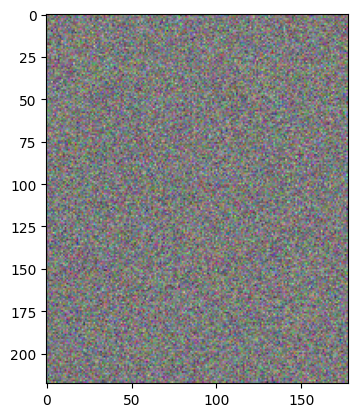

In [34]:
i = 0
print(f"t = {xs[i, 5, 1, 1]}")
img = xs[i, 0:3, :, :].permute(1, 2, 0)
img -= torch.min(img)
img /= torch.max(img)
plt.imshow(xs[0, 0:3, :, :].permute(1, 2, 0))

In [58]:
from neuralop.models import UNO

operator = UNO(
    in_channels=6, 
    out_channels=3,
    hidden_channels=128, 
    lifting_channels=256,
    projection_channels=256,
    n_layers=4,
    uno_out_channels=[128, 64, 64, 128],
    uno_n_modes=[[128, 128], [128, 128], [128, 128], [128, 128]],
    uno_scalings=[[2, 2], [2, 2], [0.5, 0.5], [0.5, 0.5]],  
)

operator(xs).shape

[128, 64, 64, 128]


torch.Size([5, 3, 218, 178])

In [1]:
# import torch
# from torch import nn
# from diffusion.noise_scheduler import NoiseScheduler


# class Model(nn.Module):
#     def __init__(self, noise_scheduler: NoiseScheduler):
#         super().__init__()
#         embedding_w = torch.randn(256//2)
#         self.register_buffer("embedding_w", embedding_w)

#         self.noise_scheduler = noise_scheduler

#         self.channels = [3, 16, 32, 64, 128, 256]
#         self.act = nn.GELU()

#         self.conv1 = nn.Conv2d(self.channels[0], self.channels[1], (3, 3), padding=(1, 1))
#         self.d1 = nn.Linear(256, self.channels[1])
#         self.pool1 = nn.MaxPool2d((2, 2))
#         self.n1 = nn.GroupNorm(16, self.channels[1])
#         self.conv2 = nn.Conv2d(self.channels[1], self.channels[2], (3, 3), padding=(1, 1))
#         self.d2 = nn.Linear(256, self.channels[2])
#         self.pool2 = nn.MaxPool2d((2, 2), stride=(1, 1))
#         self.n2 = nn.GroupNorm(32, self.channels[2])
#         self.conv3 = nn.Conv2d(self.channels[2], self.channels[3], (3, 3), padding=(1, 1))
#         self.d3 = nn.Linear(256, self.channels[3])
#         self.pool3 = nn.MaxPool2d((2, 2))
#         self.n3 = nn.GroupNorm(32, self.channels[3])
#         self.conv4 = nn.Conv2d(self.channels[3], self.channels[4], (3, 3), padding=(1, 1))
#         self.d4 = nn.Linear(256, self.channels[4])
#         self.pool4 = nn.MaxPool2d((2, 2))
#         self.n4 = nn.GroupNorm(32, self.channels[4])
#         self.conv5 = nn.Conv2d(self.channels[4], self.channels[5], (3, 3), padding=(1, 1))
#         self.d5 = nn.Linear(256, self.channels[5])
#         self.n5 = nn.GroupNorm(32, self.channels[5])
        
#         self.dt5 = nn.Linear(256, self.channels[4])
#         self.convt5 = nn.ConvTranspose2d(self.channels[5], self.channels[4], (3, 3), padding=(1, 1))
#         self.nt5 = nn.GroupNorm(32, self.channels[4])
#         self.up4 = nn.ConvTranspose2d(2*self.channels[4], self.channels[3], (2, 2), stride=(2, 2))
#         self.dt4 = nn.Linear(256, self.channels[3])
#         self.convt4 = nn.ConvTranspose2d(self.channels[3], self.channels[3], (3, 3), padding=(1, 1))
#         self.nt4 = nn.GroupNorm(32, self.channels[3])
#         self.up3 = nn.ConvTranspose2d(2*self.channels[3], self.channels[2], (2, 2), stride=(2, 2))
#         self.dt3 = nn.Linear(256, self.channels[2])
#         self.convt3 = nn.ConvTranspose2d(self.channels[2], self.channels[2], (3, 3), padding=(1, 1))
#         self.nt3 = nn.GroupNorm(32, self.channels[2])
#         self.up2 = nn.ConvTranspose2d(2*self.channels[2], self.channels[1], (2, 2), stride=(1, 1))
#         self.dt2 = nn.Linear(256, self.channels[1])
#         self.convt2 = nn.ConvTranspose2d(self.channels[1], self.channels[1], (3, 3), padding=(1, 1))
#         self.nt2 = nn.GroupNorm(16, self.channels[1])
#         self.up1 = nn.ConvTranspose2d(2*self.channels[1], self.channels[0], (2, 2), stride=(2, 2))
#         self.dt1 = nn.Linear(256, self.channels[0])
#         self.convt1 = nn.ConvTranspose2d(self.channels[0], self.channels[0], (3, 3), padding=(1, 1))
#         self.nt1 = nn.GroupNorm(3, self.channels[0])

#     def embed(self, ts, linear):
#         embedding = 30 * torch.outer(ts, self.embedding_w)
#         embedding = torch.cat([torch.sin(embedding), torch.cos(embedding)], dim=1)
#         embedding = self.act(linear(embedding))
#         embedding = embedding.reshape(*embedding.shape, 1, 1)

#         return embedding

#     def forward(self, xs, ts):
#         h1 = self.conv1(xs)
#         h1 += self.embed(ts, self.d1)
#         h1 = self.pool1(h1)
#         h1 = self.n1(h1)
#         h1 = self.act(h1)

#         h2 = self.conv2(h1)
#         h2 += self.embed(ts, self.d2)
#         h2 = self.pool2(h2)
#         h2 = self.n2(h2)
#         h2 = self.act(h2)

#         h3 = self.conv3(h2)
#         h3 += self.embed(ts, self.d3)
#         h3 = self.pool3(h3)
#         h3 = self.n3(h3)
#         h3 = self.act(h3)

#         h4 = self.conv4(h3)
#         h4 += self.embed(ts, self.d4)
#         h4 = self.pool4(h4)
#         h4 = self.n4(h4)
#         h4 = self.act(h4)

#         h5 = self.conv5(h4)
#         h5 += self.embed(ts, self.d5)
#         h5 = self.n5(h5)
#         h5 = self.act(h5)


#         h = self.convt5(h5)
#         h += self.embed(ts, self.dt5)
#         h = self.nt5(h)
#         h = self.act(h)

#         h = self.up4(torch.cat((h, h4), dim=1))
#         h += self.embed(ts, self.dt4)
#         h = self.convt4(h)
#         h = self.nt4(h)
#         h = self.act(h)

#         h = self.up3(torch.cat((h, h3), dim=1))
#         h += self.embed(ts, self.dt3)
#         h = self.convt3(h)
#         h = self.nt3(h)
#         h = self.act(h)

#         h = self.up2(torch.cat((h, h2), dim=1))
#         h += self.embed(ts, self.dt2)
#         h = self.convt2(h)
#         h = self.nt2(h)
#         h = self.act(h)

#         h = self.up1(torch.cat((h, h1), dim=1))
#         h = self.convt1(h)
#         h = self.nt1(h)

#         # return h

#         print(h.shape)

# model = Model(NoiseScheduler(0, 0.02, 1000))

# # add noise
# ts = torch.randint(1, model.noise_scheduler.steps, (len(xs),))
# xs, ys = model.noise_scheduler.forward_process(xs, ts)

# model(xs, ts)